In [15]:
import numpy as np
import forward.common as common
import forward.homogeneous_semi_inf as hsi
import utils.noise as noise
import inverse.fit_homogeneous_semi_inf as fhsi
import inverse.mbl_homogeneous_semi_inf as mbl
import matplotlib.pyplot as plt

# Generate some curves

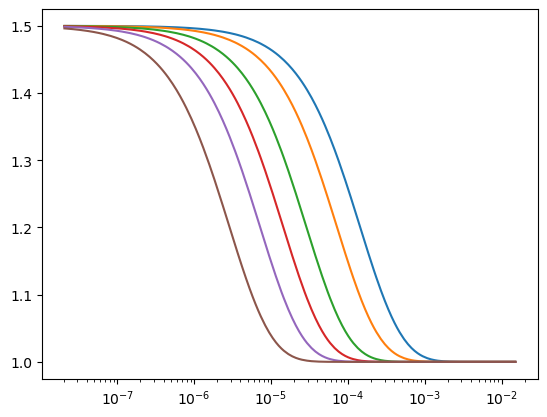

In [39]:
tau = np.load("tau.npy") # Load tau values
tau = tau[tau > 2e-8]
lambda0 = 785
mua = 0.01
musp = 10
rho = 2
n = 1.4
db = [1e-9, 2e-9, 5e-9, 1e-8, 2e-8, 5e-8]
beta = 0.5
g1_norm = np.zeros((len(tau), len(db)))
g2_norm = np.zeros((len(tau), len(db)))
for i in range(len(db)):
    msd = common.msd_brownian(tau, db[i])
    g1_norm[:, i] = hsi.g1_norm(msd, mua, musp, rho, n, lambda0)

g2_norm = 1 + beta * g1_norm**2
plt.semilogx(tau, g2_norm)
plt.show()

# Add noise

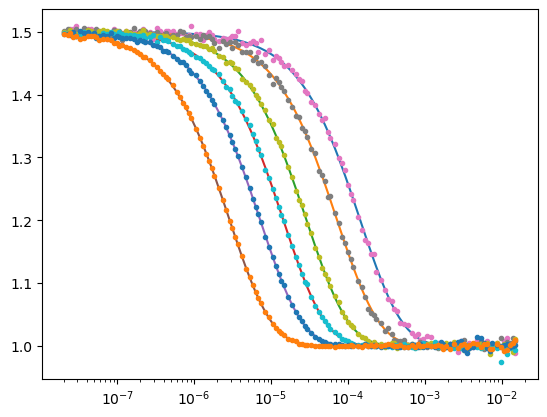

In [49]:
noise_adder = noise.NoiseAdder(
    g2_norm=g2_norm,
    tau=tau,
    t_integration=1,
    countrate=50e5,
    beta=0.5,
    n_speckle=4,
    mua=mua,
    musp=musp,
    db=np.array(db),
    lambda0=lambda0
)

g2_norm_noisy = noise_adder.add_noise()
plt.semilogx(tau, g2_norm)
plt.semilogx(tau, g2_norm_noisy, linestyle='none', marker='.')
plt.show()

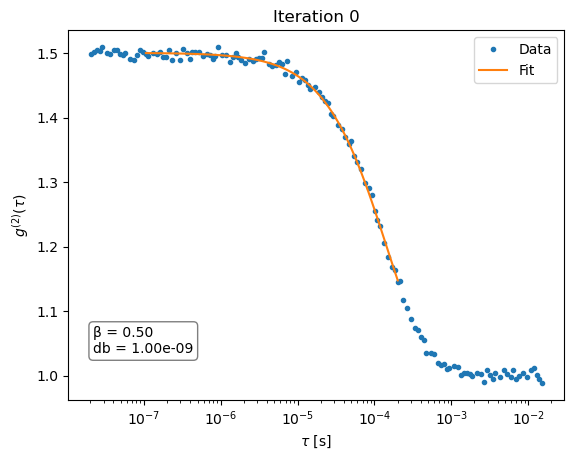

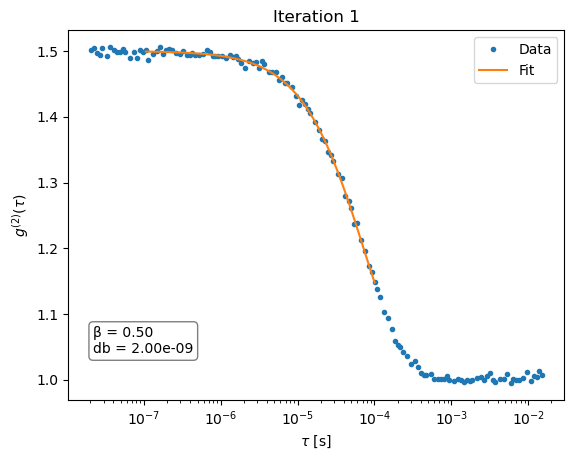

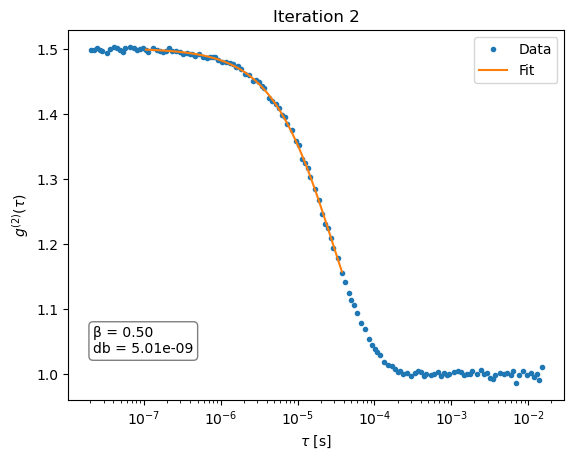

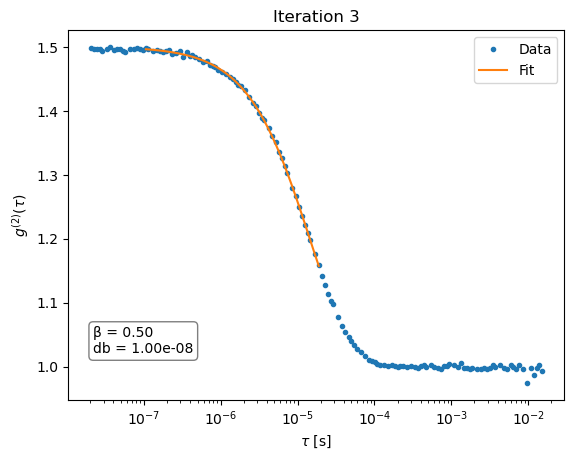

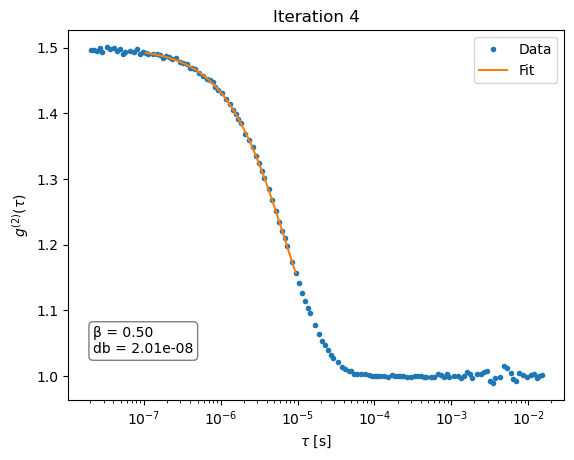

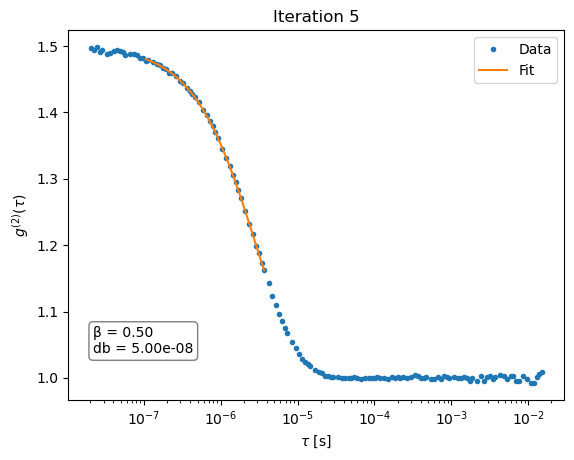

,db,beta
0,1.002229e-09,0.500263
1,1.999830e-09,0.500026
2,5.008070e-09,0.500895
3,1.001212e-08,0.500621
4,2.006864e-08,0.500070
5,4.996593e-08,0.499809


In [52]:
#beta_calculator =  fhsi.BetaCalculator(mode="fixed", beta_fixed=0.50)
#beta_calculator = fhsi.BetaCalculator(mode="raw", tau_lims=(1e-7, 2e-7))
beta_calculator = fhsi.BetaCalculator(mode="fit", beta_init=0.48, beta_bounds=(0.47, 0.51))
msd_model = fhsi.MSDModel(model_name="brownian", param_init={"db": 1e-8}, param_bounds={"db": (0, None)})
#msd_model = fhsi.MSDModel(model_name="ballistic", param_init={"v_ms": 1e-4}, param_bounds={"v_ms": (0, None)})
#msd_model = fhsi.MSDModel(model_name="hybrid", param_init={"db": 1e-8, "v_ms": 1e-4}, param_bounds={"db": (0, None), "v_ms": (0, None)})
fitter = fhsi.FitHomogeneousSemiInf(
    tau,
    g2_norm_noisy,
    mua,
    musp,
    rho,
    n,
    lambda0,
    msd_model,
    beta_calculator,
    tau_lims_fit=(1e-7, 1e-3),
    g2_lim_fit=1.13,
    plot_interval=1,
    nfr=False,
    time_integration=1,
    countrate=50e3,
    n_speckle=4
)

fitted_data = fitter.fit()
fitted_data

C:\Users\marco\PycharmProjects\Fit-DCS\inverse\mbl_homogeneous_semi_inf.py:115: RuntimeWarning: invalid value encountered in log
  delta_od = -np.log((self.g2_norm - 1) / (g2_norm_0 - 1))


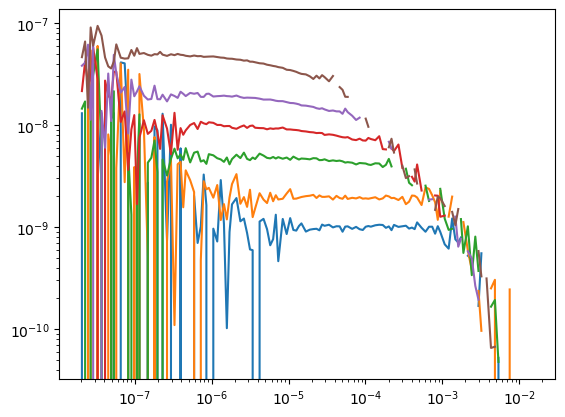

In [53]:
mbl_analyzer = mbl.MBLHomogeneousSemiInf(
    tau,
    g2_norm_noisy,
    mua,
    musp,
    rho,
    n,
    lambda0,
    g2_norm[:, 0],
    mua,
    musp,
    db[0]
)

db_calculated = mbl_analyzer.fit()
plt.loglog(tau, db_calculated)
plt.show()

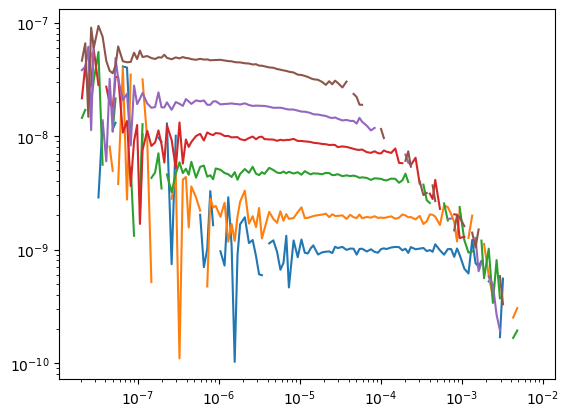

array([1.01006511e-09, 1.96479354e-09, 4.55974963e-09, 8.93706323e-09,
       1.77692003e-08, 3.95405436e-08])

In [54]:
# Plot only the db values that are neither too big (1e-6) nor too small (1e-10)
db_calculated_plot = np.where((db_calculated > 1e-10) & (db_calculated < 1e-6), db_calculated, np.nan)
plt.figure()
plt.loglog(tau, db_calculated_plot)
plt.show()

np.nanmedian(db_calculated_plot, axis=0)